In [1]:
import tensorflow as tf
print(tf.__version__)
import sys

import tensorflow as tf
import numpy as np
import os
import pickle

from data_utils.data_helpers import genFeatures, loadVocabEmb
from data_utils.tag_data_helpers import genPOSFeatures
from data_utils.eval_helpers import plot_roc_auc
from experiments import params
from model.abuse_classifier import AbuseClassifier
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False


1.15.0


In [2]:
#define the model type and attention loss type we are testing

MODEL_TYPE = "model_noatt_checkpoints"
ATTENTION_LOSS_TYPE = "encoded"
comm_or_sent = "comm"

#if model type is no attention, attention lambda should be 0
if MODEL_TYPE == "model_noatt_checkpoints":
    attention_lambda = 0.0
    ATTENTION_LOSS_TYPE = "none"
else:
    attention_lambda = 0.2

In [3]:
#these thresholds were found by seeing which threshold yielded the best f1 score in the training data
#best threshold for attention model and non attention model came out to be the same
BEST_THRESHOLD = 0.3

In [4]:
flags = tf.app.flags


# Model Hyperparameters
tf.flags.DEFINE_integer("embedding_dim", 300, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_integer("pos_vocab_size", 26, "Vocab size of POS tags")
tf.flags.DEFINE_integer("pos_embedding_dim", 25, "Dimensionality of pos tag embedding (default: 20)")
tf.flags.DEFINE_float("dropout_keep_prob", 1.0, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("attention_lambda", attention_lambda, "Supervised attention lambda (default: 0.05)")
tf.flags.DEFINE_string("attention_loss_type", ATTENTION_LOSS_TYPE, "loss function of attention")
tf.flags.DEFINE_float("l2_reg_lambda", 0.02, "L2 regularization lambda (default: 0.05)")
tf.flags.DEFINE_integer("hidden_size", 300, "Dimensionality of RNN cell (default: 300)")
tf.flags.DEFINE_integer("pos_hidden_size", 25, "Dimensionality of POS-RNN cell")
tf.flags.DEFINE_integer("attention_size", 20, "Dimensionality of attention scheme (default: 50)")
tf.flags.DEFINE_boolean("use_pos_flag", True, "use the sequence of POS tags")
# Training parameters -- evaluate_every should be 100
tf.flags.DEFINE_integer("batch_size", 32, "Batch Size (default: 32)")
tf.flags.DEFINE_integer("num_epochs", 60, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 50, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 500000, "Save model after this many steps (default: 100)")
# tf.flags.DEFINE_float("train_ratio", 1.0, "Ratio of training data")
# Misc Parameters
tf.flags.DEFINE_string("checkpoint", '', "model")
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")
tf.app.flags.DEFINE_string('f', '', 'kernel')
FLAGS = flags.FLAGS

In [5]:



def load_vocab():
    vocabulary, pos_vocabulary, init_embed = loadVocabEmb()
    return vocabulary, pos_vocabulary, init_embed


def load_data(dump_folder_path, data_folder_path, data_type, verbose=True):
    assert data_type in ["train", "test"]
    with open(os.path.join(dump_folder_path, "vocab.pkl"), "rb") as handle:
        vocabulary = pickle.load(handle)
    with open(os.path.join(dump_folder_path, "pos_vocab.pkl"), "rb") as handle:
        pos_vocabulary = pickle.load(handle)
        
        
        
    #loading actual data    
    with open(os.path.join(data_folder_path, data_type + f"_{comm_or_sent}.data"), "rb") as handle:
        sentences, labels = pickle.load(handle)
    with open(os.path.join(data_folder_path, data_type + f"_{comm_or_sent}_pos.data"), "rb") as handle:
        pos_sentences = pickle.load(handle)
    with open(os.path.join(data_folder_path, data_type + "_attention.data"), "rb") as handle:
        attention = pickle.load(handle)
    # generate features & labels
    x, length, attention = genFeatures(sentences, attention, params.max_sent_len, vocabulary)
    pos, pos_length = genPOSFeatures(pos_sentences, params.max_sent_len, pos_vocabulary, False)
    y = np.array(labels)
    if verbose:
        print("load {} data, input sent size: {}, input POS size: {}, label size: {}".format(
            data_type, np.array(x).shape, np.array(pos).shape, np.array(y).shape))
        
        
        
    x_test, length_test, attention_test, pos_test, pos_length_test, y_test = x, length, attention, pos, pos_length, y
    return x_test, length_test, attention_test, pos_test, pos_length_test, y_test


def get_predictions(model_path, dump_folder_path, data_folder_path, data_type="test"):
    with open(os.path.join(dump_folder_path, "norm_init_embed.pkl"), "rb") as handle:
        init_embed = pickle.load(handle)

    
    
    x_test, length_test, attention_test, pos_test, pos_length_test, y_test = load_data(dump_folder_path, data_folder_path, data_type,  verbose=False)
    
    len_data = len(x_test)
    print(f"Running model on {len_data} {data_type} samples")

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
            allow_soft_placement=FLAGS.allow_soft_placement,
            log_device_placement=FLAGS.log_device_placement
        )
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            model = AbuseClassifier(
                max_sequence_length=params.max_sent_len,
                num_classes=2,
                pos_vocab_size=FLAGS.pos_vocab_size,
                init_embed=init_embed,
                hidden_size=FLAGS.hidden_size,
                attention_size=FLAGS.attention_size,
                keep_prob=FLAGS.dropout_keep_prob,
                attention_lambda=FLAGS.attention_lambda,
                attention_loss_type=FLAGS.attention_loss_type,
                l2_reg_lambda=0.1,
                use_pos_flag=FLAGS.use_pos_flag)

            global_step = tf.Variable(0, name="global_step", trainable=False)
            saver = tf.train.Saver(tf.all_variables())
            # Initialize all variables
            sess.run(tf.initialize_all_variables())
            saver.restore(sess, model_path)

            dev_scores = []
            dev_confidences = []
            alphas = []
            pos = 0
            gap = 50
            while pos < len(x_test):
                x_batch = x_test[pos:pos + gap]
                pos_batch = pos_test[pos:pos + gap]
                y_batch = y_test[pos:pos + gap]
                length_batch = length_test[pos:pos + gap]
                pos_length_batch = pos_length_test[pos:pos + gap]
                pos += gap
                # score sentences
                feed_dict = {
                    model.input_word: x_batch,
                    model.input_pos: pos_batch,
                    model.input_y: y_batch,
                    model.sequence_length: length_batch,
                    model.dropout_keep_prob: 1.0
                }
                step, scores, alpha = sess.run([global_step, model.prob, model.alphas], feed_dict)
                dev_confidences = dev_confidences + list([[s[0],s[1]] for s in scores])
                dev_scores = dev_scores + list([s[0] for s in scores])
                alphas = alphas + list(alpha)
    return dev_confidences, dev_scores, y_test, alphas




In [148]:



#path to get testing data from 
TEST_DATA_PATH = "experiments/data/exp_4/adv/"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
model_save_folder_name = MODEL_TYPE
print(f"Running model from {model_save_folder_name}")

model_folder_path = 'model'
checkpoint_dir = os.path.abspath(os.path.join(model_folder_path, model_save_folder_name))
model_path = os.path.join(checkpoint_dir, "best_model")

dump_folder_path = 'dump_2'
print(f"Testing on data: {TEST_DATA_PATH}")
print(f"Using vocab/embed from {dump_folder_path}")

scores, predictions, ground_truth, alphas = get_predictions(model_path, dump_folder_path, TEST_DATA_PATH, "test")

ground_truth = [g[0] for g in ground_truth]

print("Done")
print("-" * 100)
print(f"Ran model from {model_save_folder_name}, using data from {TEST_DATA_PATH}")

print("Predictions:")
print(scores[0:10])

print("Ground Truth:")
print(ground_truth[0:10])

print("Classification:")
y_pred = list(map(lambda p: 1 if p > BEST_THRESHOLD else 0, predictions))
print(y_pred[0:10])


Running model from model_noatt_checkpoints
Testing on data: experiments/data/exp_4/adv/
Using vocab/embed from dump_2
padded sent: (11540, 100)
feature shape: (11540, 100)
Running model on 11540 test samples
No supervised attention.
INFO:tensorflow:Restoring parameters from C:\Users\apra\Desktop\FALL 2021\CY 7990\toxicity_filter_attacks\model\model_noatt_checkpoints\best_model
Done
----------------------------------------------------------------------------------------------------
Ran model from model_noatt_checkpoints, using data from experiments/data/exp_4/adv/
Predictions:
[[0.17605248, 0.8239475], [0.367915, 0.632085], [0.72552395, 0.27447608], [0.1895721, 0.8104279], [0.17357463, 0.82642543], [0.15778123, 0.8422188], [0.5411559, 0.4588441], [0.71996665, 0.2800333], [0.75829995, 0.24170004], [0.18930493, 0.81069505]]
Ground Truth:
[0, 1, 1, 0, 0, 0, 0, 1, 1, 0]
Classification:
[0, 1, 1, 0, 0, 0, 1, 1, 1, 0]


In [149]:
from data_utils import eval_helpers
from sklearn.metrics import f1_score, accuracy_score
print("TEST METRICS: \n")
# roc auc
eval_helpers.evalROC(ground_truth, predictions)
# pr auc
eval_helpers.evalPR(ground_truth, predictions)
# f1 score
fscore = f1_score(ground_truth, y_pred)
print("fscore: {}".format(fscore))

accuracy = accuracy_score(ground_truth,y_pred)
print("accuracy: {}".format(fscore))

TEST METRICS: 

roc_auc: 0.8378348556079827
pr_auc: 0.6849461325122604
fscore: 0.6354288689314069
accuracy: 0.6354288689314069


In [150]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def colorize(words, color_array):
    # words is a list of words
    # color_array is an array of numbers between 0 and 1 of length equal to words
    cmap = cmap=matplotlib.cm.Reds
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string
def plot_attention(tokenized_comment, attention_weights, seperate = False):
    len_comment = len(tokenized_comment)

    if seperate:
        print("====FORWARD ATTENTION===")
        s = colorize(tokenized_comment, attention_weights[0:50])
        display(HTML(s))   
        print("====BACKWORD ATTENTION===")
        s = colorize(tokenized_comment, attention_weights[50:])
        display(HTML(s))    
    else:
        s = colorize(tokenized_comment, attention_weights[0:50]+attention_weights[50:])
        display(HTML(s))
   


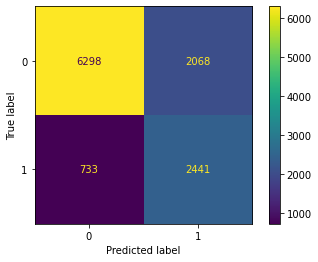

In [151]:
#some visualizations

from  sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, RocCurveDisplay
cm = confusion_matrix(ground_truth, y_pred)
ConfusionMatrixDisplay(cm).plot()

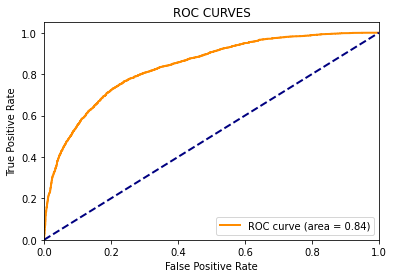

In [152]:
plot_roc_auc(ground_truth,predictions)

In [153]:
#let's vizualize some stuff!

#first, I want to print comments and their ground truth and predicted labels

with open(os.path.join(TEST_DATA_PATH, "test_raw_comm.data"), "rb") as handle:
    comm_list, label_list = pickle.load(handle)
with open(os.path.join(TEST_DATA_PATH, "test_comm.data"), "rb") as handle:
    tok_comm_list, label_list = pickle.load(handle)

In [156]:
import random
good_viz = [1239,833,606,610]
for i in random.sample(range(0, len(y_pred)), 10):
#for i in good_viz:
    correct_pred = (label_list[i][0] == y_pred[i])
    if correct_pred:
        print("====CORRECT====")
    else:
        print("====INCORRECT====")
        
    plot_attention(tok_comm_list[i], alphas[i])
    print(f"({i})   True: {label_list[i][0]} Predicted {y_pred[i]}, (Score: {predictions[i]})", "\n")

====CORRECT====


(1570)   True: 0 Predicted 0, (Score: 0.239008828997612) 

====CORRECT====


(5245)   True: 1 Predicted 1, (Score: 0.516926646232605) 

====CORRECT====


(10504)   True: 0 Predicted 0, (Score: 0.18325333297252655) 

====CORRECT====


(9713)   True: 0 Predicted 0, (Score: 0.2752135694026947) 

====INCORRECT====


(8620)   True: 0 Predicted 1, (Score: 0.31177154183387756) 

====CORRECT====


(3442)   True: 1 Predicted 1, (Score: 0.33428695797920227) 

====CORRECT====


(2586)   True: 1 Predicted 1, (Score: 0.5278081297874451) 

====CORRECT====


(1804)   True: 1 Predicted 1, (Score: 0.3309004008769989) 

====CORRECT====


(9734)   True: 0 Predicted 0, (Score: 0.16880623996257782) 

====INCORRECT====


(7793)   True: 0 Predicted 1, (Score: 0.3690403699874878) 



In [6]:
#tune threshold using train
def tuneThreshold(gold_scores, pred_scores):
    from  sklearn.metrics import f1_score
    best_t = 0.0
    best_fscore = 0.0
    for t in np.arange(0, 1.1, 0.1):
        pred_labels = [int(s > t) for s in pred_scores]
        fscore = f1_score(gold_scores, pred_labels)
        if (best_fscore < fscore):
            best_fscore = fscore
            best_t = t
    return best_t, best_fscore

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
model_save_folder_name = MODEL_TYPE
print(f"Running model from {model_save_folder_name}")

model_folder_path = 'model'
checkpoint_dir = os.path.abspath(os.path.join(model_folder_path, model_save_folder_name))
model_path = os.path.join(checkpoint_dir, "best_model")

data_path = 'dump_2'
print(f"Using data from {data_path}")

scores, predictions, ground_truth = get_predictions(model_path, data_path, "train")

print("Done")
print("-" * 100)
print(f"Ran model from {model_save_folder_name}, using data from {data_path}")


ground_truth_pos = [gt[0] for gt in ground_truth ]
best_t, best_fscore = tuneThreshold(ground_truth_pos, predictions)
print("Best Threshold on Train: ", best_t)
print("Best F1 Score on Train: ", best_fscore)

print("Predictions:")
print(scores[0:10])

print("Ground Truth:")
print(ground_truth[0:10])

print("Classification:")
y_pred = list(map(lambda p: 1 if p > best_t else 0, predictions))
print(y_pred[0:10])


Running model from model_noatt_checkpoints
Using data from dump_2
padded sent: (9232, 100)
feature shape: (9232, 100)
Running model on 9232 train samples
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into

In [8]:
from data_utils import eval_helpers
from sklearn.metrics import f1_score

print("TRAIN METRICS: \n")
# roc auc
eval_helpers.evalROC(ground_truth_pos, predictions)
# pr auc
eval_helpers.evalPR(ground_truth_pos, predictions)

fscore = f1_score(ground_truth_pos, y_pred)
print("fscore: {}".format(fscore))

TRAIN METRICS: 

roc_auc: 0.8292982557173499
pr_auc: 0.6840993120084116
fscore: 0.6273476112026359
